In [1]:
import numpy as np
from importlib import reload
from glob import glob
import os
import torchvision
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from utilities.utils import get_preprocessed_images_paths
from utilities.datasets import SegDatasetFromTensors, BasicDataset

%load_ext autoreload
%autoreload 2


In [2]:
paths = get_preprocessed_images_paths(128, file_extension_img='.pt', file_extension_mask='.pt', refresh_search=True)

# Extracting all the paths into individual variables
train_images = paths['train_images']
train_masks = paths['train_masks']
train_images_cropped = paths['train_images_cropped']
train_masks_cropped = paths['train_masks_cropped']
val_images = paths['val_images']
val_masks = paths['val_masks']
val_images_cropped = paths['val_images_cropped']
val_masks_cropped = paths['val_masks_cropped']
test_images = paths['test_images']
test_masks = paths['test_masks']
train_images_resized = paths['train_images_resized']
train_masks_resized = paths['train_masks_resized']


# Load the training dataset with uncropped images
train_dataset = SegDatasetFromTensors(input_img=train_images, masks=train_masks, normalize_images=False, is_training=True)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

# Load the training dataset with resized images
train_resized_dataset = SegDatasetFromTensors(input_img=train_images_resized, masks=train_masks_resized, normalize_images=False)
train_resized_loader = DataLoader(train_resized_dataset, batch_size=1, shuffle=False)

# Load the training dataset with cropped images
train_cropped_dataset = SegDatasetFromTensors(input_img=train_images_cropped, masks=train_masks_cropped, normalize_images=False, is_training=True)
train_cropped_loader = DataLoader(train_cropped_dataset, batch_size=1, shuffle=False)

# Load the validation dataset
val_dataset = SegDatasetFromTensors(input_img=val_images, masks=val_masks, normalize_images=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

val_cropped_dataset = SegDatasetFromTensors(input_img=val_images_cropped, masks=val_masks_cropped, normalize_images=False)
val_cropped_loader = DataLoader(val_cropped_dataset, batch_size=1, shuffle=False)

# Load the test dataset
test_dataset = SegDatasetFromTensors(input_img=test_images, masks=test_masks, normalize_images=False)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

crop_images = sorted(glob(os.path.join('cropped/*png')), key=lambda x: os.path.basename(x))

test_cropped = BasicDataset(crop_images)
test_cropped_loader = DataLoader(test_cropped, batch_size=1, shuffle=False)


In [3]:


def compute_mean_std(loader, loader_name):
    # Initialize counters and sums
    total_pixels = 0
    sum_r, sum_g, sum_b = 0.0, 0.0, 0.0
    sum_sq_r, sum_sq_g, sum_sq_b = 0.0, 0.0, 0.0
    
    # Loop over the DataLoader
    for images, _ in tqdm(loader, total=len(loader)):
        
        # Iterate over batch
        for img in images:
            img = img.cpu().numpy()
            
            
            # Mask zero values by checking all channels
            mask = (img[0] != 0) | (img[1] != 0) | (img[2] != 0)
            
            # Get non-zero values for each channel
            r_values = img[0][mask]
            g_values = img[1][mask]
            b_values = img[2][mask]
            
            # Update sums and sums of squares for each channel
            total_pixels += r_values.size  # Count number of valid pixels
            sum_r += np.sum(r_values)
            sum_g += np.sum(g_values)
            sum_b += np.sum(b_values)
            
            sum_sq_r += np.sum(r_values ** 2)
            sum_sq_g += np.sum(g_values ** 2)
            sum_sq_b += np.sum(b_values ** 2)
    
    # Compute means for each channel
    mean_r = sum_r / total_pixels
    mean_g = sum_g / total_pixels
    mean_b = sum_b / total_pixels
    
    # Compute standard deviations for each channel
    std_r = np.sqrt((sum_sq_r / total_pixels) - (mean_r ** 2))
    std_g = np.sqrt((sum_sq_g / total_pixels) - (mean_g ** 2))
    std_b = np.sqrt((sum_sq_b / total_pixels) - (mean_b ** 2))
    
    # Print results
    print(f"{loader_name} Mean (R, G, B): {mean_r}, {mean_g}, {mean_b}")
    print(f"{loader_name} Std (R, G, B): {std_r}, {std_g}, {std_b}")
    



In [4]:
compute_mean_std(train_loader, "Train Loader")
compute_mean_std(train_cropped_loader, 'cropped')
compute_mean_std(val_loader, 'validation')
compute_mean_std(val_cropped_loader, 'validation_cropped')
#compute_mean_std(test_loader, 'Test Loader')
#compute_mean_std(test_cropped_loader, 'cropped_test')


  0%|          | 0/4000 [00:00<?, ?it/s]

Train Loader Mean (R, G, B): 0.32975525795939176, 0.19380269262000854, 0.09536543735334127
Train Loader Std (R, G, B): 0.15924140217604812, 0.09941648653382394, 0.055644066488547195


  0%|          | 0/4000 [00:00<?, ?it/s]

cropped Mean (R, G, B): 0.5966441725144175, 0.3379078947970837, 0.16812422227171137
cropped Std (R, G, B): 0.23238039928303286, 0.1880428751274462, 0.10398509273908875


  0%|          | 0/400 [00:00<?, ?it/s]

validation Mean (R, G, B): 0.5507591776382487, 0.36368202300487135, 0.28958523739594133
validation Std (R, G, B): 0.17806627200735062, 0.14194286672976278, 0.10991587430013793


  0%|          | 0/400 [00:00<?, ?it/s]

validation_cropped Mean (R, G, B): 0.7747499612220803, 0.555246008680849, 0.4268781335953457
validation_cropped Std (R, G, B): 0.15772318335876612, 0.16953635063353217, 0.14195184914719983


In [7]:
# Load the training dataset with uncropped images
train_dataset = SegDatasetFromTensors(input_img=train_images, masks=train_masks, ratio=1 ,normalize_images=True, is_training=True)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=False)

# Load the training dataset with resized images
train_resized_dataset = SegDatasetFromTensors(input_img=train_images_resized, masks=train_masks_resized, normalize_images=False)
train_resized_loader = DataLoader(train_resized_dataset, batch_size=1, shuffle=False)

# Load the training dataset with cropped images
train_cropped_dataset = SegDatasetFromTensors(input_img=None, masks=None, 
                                              cropped_input=train_images_cropped, cropped_masks=train_masks_cropped,
                                              ratio=0, normalize_images=True, is_training=True)
train_cropped_loader = DataLoader(train_cropped_dataset, batch_size=1, shuffle=False)

# Load the validation dataset
val_dataset = SegDatasetFromTensors(input_img=val_images, masks=val_masks, normalize_images=True, is_training=False)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)


val_cropped_dataset = SegDatasetFromTensors(input_img=val_images_cropped, masks=val_masks_cropped, cropped_input=val_images_cropped, cropped_masks=val_masks_cropped , ratio=0, normalize_images=True, is_training=False)
val_cropped_loader = DataLoader(val_cropped_dataset, batch_size=1, shuffle=False)
# Load the test dataset
test_dataset = SegDatasetFromTensors(input_img=test_images, masks=test_masks, normalize_images=True, is_training=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

crop_images = sorted(glob(os.path.join('cropped/*png')), key=lambda x: os.path.basename(x))

test_cropped = BasicDataset(crop_images)
test_cropped_loader = DataLoader(test_cropped, batch_size=1, shuffle=False)

In [8]:

# Example usage:
#compute_mean_std(train_loader, "Train Loader")
#compute_mean_std(train_cropped_loader, 'cropped')
#compute_mean_std(val_loader, 'validation')
compute_mean_std(val_cropped_loader, 'validation_cropped')


  0%|          | 0/4000 [00:00<?, ?it/s]

Train Loader Mean (R, G, B): -0.055291307811253555, -0.049953110508477866, -0.05565495431107074
Train Loader Std (R, G, B): 0.9978411828740444, 0.9888898740391605, 1.0063736633499167


  0%|          | 0/4000 [00:00<?, ?it/s]

cropped Mean (R, G, B): 3.221064142374239e-08, 5.566719258606829e-08, -1.3226395086711867e-07
cropped Std (R, G, B): 0.9999999732829887, 1.0000000057160512, 1.0000000870541066


  0%|          | 0/400 [00:00<?, ?it/s]

validation Mean (R, G, B): 4.498461327058267e-05, 0.002967559555664965, 0.00377206300339498
validation Std (R, G, B): 0.9999302619072687, 0.9961864593394519, 0.9950114915504317


  0%|          | 0/400 [00:00<?, ?it/s]

validation_cropped Mean (R, G, B): 9.11178684298906e-05, 0.00016899316823231023, 0.00013630608568597925
validation_cropped Std (R, G, B): 0.9997765731490914, 0.999723290744797, 0.9997950890554188


In [17]:
compute_mean_std(test_cropped_loader, 'test')

  0%|          | 0/400 [00:00<?, ?it/s]

test Mean (R, G, B): 0.8418319742801653, 0.615476825913562, 0.4869731078347259
test Std (R, G, B): 0.14670943280709617, 0.18317656249631115, 0.15898107750169369


{'mean': [0.8418319742801653, 0.615476825913562, 0.4869731078347259],
 'std': [0.14670943280709617, 0.18317656249631115, 0.15898107750169369]}

100%|██████████| 400/400 [00:03<00:00, 122.36it/s]


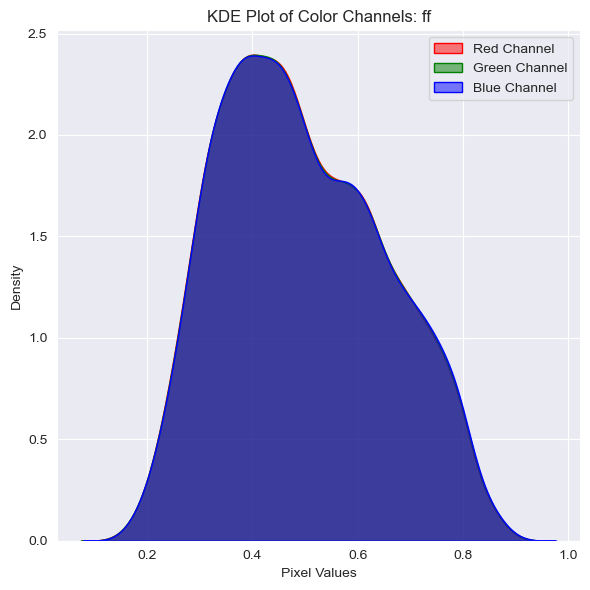

In [18]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

def kde_plot(loader: torch.utils.data.DataLoader, name):
    r_counts = {}
    g_counts = {}
    b_counts = {}
    
    for image, mask in tqdm(loader):
        r = image[:, 0]
        g = image[:, 1]
        b = image[:, 2]
        
        # Filter out zero values
        r = r[r != 0]
        g = g[g != 0]
        b = b[b != 0]
        
        # Count unique values for each channel
        r_values, r_freqs = torch.unique(r, return_counts=True)
        g_values, g_freqs = torch.unique(g, return_counts=True)
        b_values, b_freqs = torch.unique(b, return_counts=True)
        
        # Update the counts dictionary for each channel
        for val, count in zip(r_values.tolist(), r_freqs.tolist()):
            r_counts[val] = r_counts.get(val, 0) + count
            
        for val, count in zip(g_values.tolist(), g_freqs.tolist()):
            g_counts[val] = g_counts.get(val, 0) + count
            
        for val, count in zip(b_values.tolist(), b_freqs.tolist()):
            b_counts[val] = b_counts.get(val, 0) + count

    # Prepare data for KDE
    r_data = []
    g_data = []
    b_data = []

    for channel_counts, channel_data in zip([r_counts, g_counts, b_counts], [r_data, g_data, b_data]):
        for key, val in channel_counts.items():
            channel_data.extend([key] * (val // 20))  # Optional: Adjust for better visibility

    # Create KDE plots for each channel
    plt.figure(figsize=(6, 6))

    # KDE for Red channel
    sns.kdeplot(r_data, color='red', label='Red Channel', fill=True, alpha=0.5)
    
    # KDE for Green channel
    sns.kdeplot(g_data, color='green', label='Green Channel', fill=True, alpha=0.5)
    
    # KDE for Blue channel
    sns.kdeplot(b_data, color='blue', label='Blue Channel', fill=True, alpha=0.5)

    plt.title(f"KDE Plot of Color Channels: {name}")
    plt.xlabel("Pixel Values")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    #plt.savefig(f'{name}')
    plt.show()

# Usage
#kde_plot(val_loader, 'Validation dataset')
#kde_plot(train_dataset, 'Train dataset')
#kde_plot(train_cropped_dataset, 'Test dataset')
kde_plot(test_cropped, 'ff')
